In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from glob import glob
from tqdm import tqdm

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(f'Available GPU devices: {len(physical_devices)}')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Available GPU devices: 1


In [3]:
path_to_dataset = r'.\Forest fire'
path_to_training_dataset = os.path.join(path_to_dataset, 'Training')
path_to_validation_dataset = os.path.join(path_to_dataset, 'Validation')
path_to_testing_dataset = os.path.join(path_to_dataset, 'Testing')

In [4]:
def preprocessData(path):
    path_to_positive = os.path.join(path, 'fire')
    path_to_negative = os.path.join(path, 'nofire')

    images_positive = glob(path_to_positive + '/*.*')
    images_negative = glob(path_to_negative + '/*.*')

    images_list, labels_list = [], []
    for image in tqdm(images_positive):
        img = cv2.imread(image)
        img = cv2.cvtColor(img, code=cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (200, 200))
        images_list.append(img)
        labels_list.append(1)

    for image in tqdm(images_negative):
        img = cv2.imread(image)
        img = cv2.resize(img, (200, 200))
        images_list.append(img)
        labels_list.append(0)
    
    return images_list, labels_list

In [5]:
training_images_list, training_labels_list = preprocessData(path_to_training_dataset)
validation_images_list, validation_labels_list = preprocessData(path_to_validation_dataset)
testing_images_list, testing_labels_list = preprocessData(path_to_testing_dataset)

100%|██████████| 46/46 [00:00<00:00, 82.51it/s]


In [6]:
def createDataFrame(images, labels):
    dataframe = pd.DataFrame()
    dataframe['image'] = images
    dataframe['label'] = labels
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    return dataframe

dataframe_training = createDataFrame(training_images_list, training_labels_list)
dataframe_testing = createDataFrame(testing_images_list, testing_labels_list)
dataframe_validation = createDataFrame(validation_images_list, validation_labels_list)

In [7]:
X_train, y_train = dataframe_training['image'], dataframe_training['label']
X_test, y_test = dataframe_testing['image'], dataframe_testing['label']
X_val, y_val = dataframe_validation['image'], dataframe_validation['label']

def reshapeTensors(array_to_reshape, length):
    tensor = []
    for i in tqdm(range(length)):
        element = np.array(array_to_reshape[i].reshape(200, 200, 3))
        tensor.append(element)
    tensor = np.array(tensor)
    return tensor

X_train = reshapeTensors(X_train, X_train.shape[0]) / 255
X_test = reshapeTensors(X_test, X_test.shape[0]) / 255
X_val = reshapeTensors(X_val, X_val.shape[0]) / 255

100%|██████████| 497/497 [00:00<00:00, 7119.55it/s]


In [8]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [25]:
model_inceptionResNet = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(200, 200, 3))
output_layer = model_inceptionResNet.layers[-1].output
output_layer = GlobalMaxPooling2D()(output_layer)
output_layer = Flatten()(output_layer)
output_layer = Dropout(0.5)(output_layer)
model_inceptionResNet = Model(inputs=model_inceptionResNet.inputs, outputs=output_layer)
model_inceptionResNet.summary()

In [10]:
for layer in model_inceptionResNet.layers:
    layer.trainable = False

In [11]:
model = Sequential()
model.add(model_inceptionResNet)
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 1536)              54336736  
_________________________________________________________________
dense (Dense)                (None, 1024)              1573888   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0

In [12]:
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss=BinaryCrossentropy(), metrics=['accuracy'])

In [13]:
early_stopping = EarlyStopping(monitor='loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-7)

In [14]:
history = model.fit(X_train, y_train, 
                    epochs=25, batch_size=32, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, reduce_lr], verbose=1)

Epoch 1/25
54/54 [==============================] - 91s 2s/step - loss: 0.6357 - accuracy: 0.7069 - val_loss: 0.3625 - val_accuracy: 0.8491
Epoch 2/25
54/54 [==============================] - 66s 1s/step - loss: 0.3638 - accuracy: 0.8464 - val_loss: 0.3114 - val_accuracy: 0.8712
Epoch 3/25
54/54 [==============================] - 66s 1s/step - loss: 0.2806 - accuracy: 0.8921 - val_loss: 0.2646 - val_accuracy: 0.8974
Epoch 4/25
54/54 [==============================] - 65s 1s/step - loss: 0.2081 - accuracy: 0.9232 - val_loss: 0.2952 - val_accuracy: 0.9034
Epoch 5/25
54/54 [==============================] - 65s 1s/step - loss: 0.1971 - accuracy: 0.9332 - val_loss: 0.2911 - val_accuracy: 0.9014
Epoch 6/25
54/54 [==============================] - ETA: 0s - loss: 0.1650 - accuracy: 0.9426
Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
54/54 [==============================] - 65s 1s/step - loss: 0.1650 - accuracy: 0.9426 - val_loss: 0.2754 - val_accuracy: 0.9

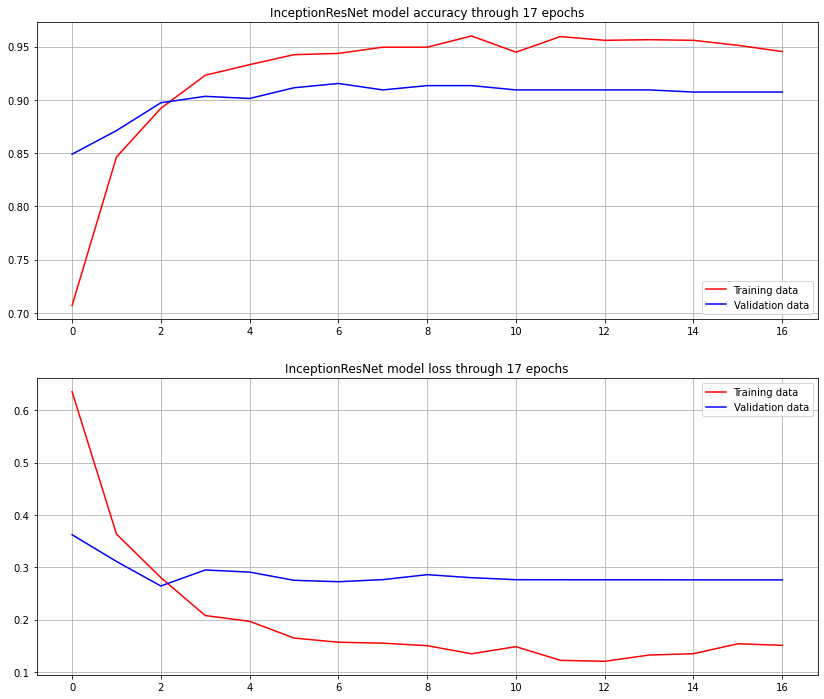

In [15]:
fig = plt.figure(figsize=(14, 12))
ax1 = fig.add_subplot(211)
ax1.set_title('InceptionResNet model accuracy through 17 epochs')
ax1.plot(history.history['accuracy'], color='red', label='Training data')
ax1.plot(history.history['val_accuracy'], color='blue', label='Validation data')
ax1.grid(True)
ax1.legend(loc='lower right')
ax2 = fig.add_subplot(212)
ax2.set_title('InceptionResNet model loss through 17 epochs')
ax2.plot(history.history['loss'], color='red', label='Training data')
ax2.plot(history.history['val_loss'], color='blue', label='Validation data')
ax2.grid(True)
ax2.legend(loc='upper right')

In [16]:
tf.keras.models.save_model(model, 'InceptionResNet.h5')

In [17]:
prediction = model.predict(X_test)

In [19]:
prediction_array = np.round(prediction)
prediction_array = prediction_array.reshape(-1).astype(np.int32)
y_test = np.array(y_test)

In [20]:
accuracy_score(y_test, prediction_array)

0.9852941176470589

In [21]:
print(classification_report(y_test, prediction_array))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        46
           1       0.96      1.00      0.98        22

    accuracy                           0.99        68
   macro avg       0.98      0.99      0.98        68
weighted avg       0.99      0.99      0.99        68



<AxesSubplot:>

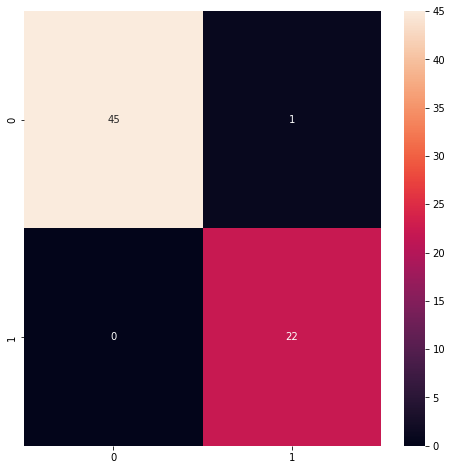

In [23]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
sns.heatmap(confusion_matrix(y_test, prediction_array), annot=True, fmt='d', ax=ax)